In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, "../nohomers")
sys.path.insert(0, "../third_party/stylegan2-ada")

In [2]:
from tqdm.auto import tqdm
import json
import torch
from pathlib import Path
from uuid import uuid4
from PIL import Image
import tempfile
import numpy as np
import ffmpeg
import shutil
import copy
import random
import dnnlib
import dnnlib.tflib as tflib
from dataclasses import dataclass, field
import pickle
from typing import Any, Dict

In [84]:
@dataclass
class Network:
    G: Any
    D: Any
    Gs: Any
        
@dataclass
class GeneratedImage:
    image: Image
    latents: np.ndarray = field(repr=False)
    style_latents: Dict[str, np.ndarray] = field(repr=False)

# Normalize batch of vectors.
def normalize(v):
    tf = tflib.tf
    return v / tf.sqrt(tf.reduce_sum(tf.square(v), axis=-1, keepdims=True))

# Spherical interpolation of a batch of vectors.
def slerpy(low, high, val):
    batch = low.size(0)
    shape_orig = low.shape
    
    low = low.reshape(batch, -1)
    high = high.reshape(batch, -1)
    low_norm = low / torch.norm(low, dim=1, keepdim=True)
    high_norm = high / torch.norm(high, dim=1, keepdim=True)
    omega = torch.acos((low_norm * high_norm).sum(-1))
    so = torch.sin(omega)
    res = (torch.sin((1.0 - val) * omega) / so).unsqueeze(1) * low + (torch.sin(val * omega) / so).unsqueeze(1) * high
    return res.reshape(shape_orig)
        
        
def load_network(network_pkl):
    tflib.init_tf()
    with dnnlib.util.open_url(str(network_pkl)) as fp:
        _G, _D, Gs = pickle.load(fp)
        
    return Network(G=_G, D=_D, Gs=Gs)
    

def set_vars_ignore_shape(var_to_value_dict: dict) -> None:
    """Set the values of given tf.Variables.

    Equivalent to the following, but more efficient and does not bloat the tf graph:
    tflib.run([tf.assign(var, value) for var, value in var_to_value_dict.items()]
    """
    tflib.assert_tf_initialized()
    ops = []
    feed_dict = {}

    for var, value in var_to_value_dict.items():
        assert tflib.is_tf_expression(var)

        try:
            with tflib.tf.control_dependencies(None):  # ignore surrounding control_dependencies
                setter = tflib.tf.assign(var, tflib.tf.placeholder(var.dtype, value.shape, "new_value"), name="setter", validate_shape=False)  # create new setter
        except KeyError:
            with tflib.absolute_name_scope(var.name.split(":")[0]):
                with tflib.tf.control_dependencies(None):  # ignore surrounding control_dependencies
                    setter = tflib.tf.assign(var, tflib.tf.placeholder(var.dtype, value.shape, "new_value"), name="setter", validate_shape=False)  # create new setter

        ops.append(setter)
        feed_dict[setter.op.inputs[1]] = value

    tflib.run(ops, feed_dict)
    
    
def generate_interpolation_frames(network, from_image, to_image, num_frames, truncation_psi=None):
    # latents and noise
    ratios = np.linspace(0., 1., num_frames) 
    
    batch_size = 1
    ret = []
    
    from_latents = np.expand_dims(from_image.latents, axis=0)
    to_latents = np.expand_dims(to_image.latents, axis=0)
    from_noise = {k: np.expand_dims(v, axis=0) for k, v in from_image.style_latents.items()}
    to_noise = {k: np.expand_dims(v, axis=0) for k, v in to_image.style_latents.items()}
    assert len(from_noise) == len(to_noise)
    noise_keys = list(from_noise.keys())
    
    for i, ratio in enumerate(tqdm(ratios)):
        if i == 0:
            z = from_latents
            noise_vars = from_noise
        elif i == len(ratios) - 1:
            z = to_latents
            noise_vars = to_noise
        else:
            z = slerpy(torch.tensor(from_latents), torch.tensor(to_latents), ratio).numpy()
            noise_vars = {
                key: slerpy(torch.tensor(from_noise[key]), torch.tensor(to_noise[key]), ratio).numpy()
                for key in noise_keys
            }
 
        generated_image = generate_images(network, num=1, truncation_psi=truncation_psi, z=z, noise_vars=noise_vars)[0]
        ret.append(generated_image.image)
    
    return ret


def frames_to_video(frames, output_path, fps=30, bitrate="1M"):
    with tempfile.TemporaryDirectory() as td:
        for i, frame in enumerate(frames):
            frame.save(Path(td) / f"{i:06d}.jpg")
            
        (
            ffmpeg
            .input(f'{td}/*.jpg', pattern_type='glob', framerate=fps)
            .output(filename=output_path, video_bitrate=bitrate)
            .overwrite_output()
            .run()
        )

def generate_images(network, truncation_psi=None, num=1, z=None, noise_vars=None):
    Gs = network.Gs
    Gs_kwargs = {                                                                       
        'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
        'randomize_noise': False
    }
    
    def replace_first_component(l, v):
        l[0] = v
        return l
    
    if truncation_psi is not None:                          
        Gs_kwargs['truncation_psi'] = truncation_psi
    
    noise_var_by_name = {var.name: var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')}
    label = np.zeros([1] + Gs.input_shapes[1][1:])    
    
    if z is None:
        z = np.random.randn(num, *Gs.input_shape[1:]) # [minibatch, component] 
        
    if noise_vars is None:
        noise_vars = {
            var: np.random.randn(*replace_first_component(var.shape.as_list(), num)) 
            for var in noise_var_by_name.values()
        }
    else:
        noise_vars = {noise_var_by_name[k]: v for k, v in noise_vars.items()}
        
        
    set_vars_ignore_shape(noise_vars) # [height, width]
    images = Gs.run(z, label, **Gs_kwargs) # [minibatch, height, width, channel]   
    
    return [
        GeneratedImage(
            image=Image.fromarray(images[i], 'RGB'),
            latents=z[i, :],
            style_latents={
                k.name: v[i, :, :, :] for k, v in noise_vars.items()
            },
        )
        for i in range(num)
    ]

In [4]:
run_path = Path("/mnt/evo/projects/metapedia/stylegan2_ada/training_runs/00000-simpsons_bart_homer_new_cleaned_256-auto1")
run_name = "network-snapshot-000483.pkl"
network = load_network(run_path / run_name)

In [61]:
from_image, to_image = generate_images(network, truncation_psi=1.2, num=2)

In [90]:
interpolation = generate_interpolation_frames(network, from_image, to_image, num_frames=30, truncation_psi=1.2)

In [64]:
output_dir = Path("/mnt/evo/projects/nohomers/tmp")
shutil.rmtree(output_dir, ignore_errors=False, onerror=None)
output_dir.mkdir(exist_ok=True)

In [91]:
frames_to_video(interpolation, output_dir / "tf_video4.mp4")

In [28]:
np.mean(( test - to_image.latents) ** 2)

0.0

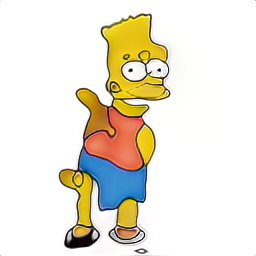

In [307]:
interpolation[-2]

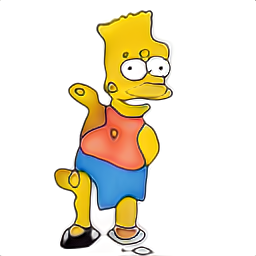

In [310]:
interpolation[-4]

In [4]:
"""
def generate_image_with_latents(self, num=1):
    self.GAN.eval()
    latent_dim = self.GAN.latent_dim
    image_size = self.GAN.image_size
    latents = torch.randn((num, latent_dim)).cuda(self.rank)
    generated_images = self.generate_truncated(self.GAN.GE, latents)
    return list(
        (latents[i, :], transforms.ToPILImage()(generated_images[i, :, :, :].cpu()))
        for i in range(num)
    )

@torch.no_grad()
def generate_interpolation_frames(self, latents_low, latents_high, num_frames):
    self.GAN.eval()
    num_rows = 1

    latent_dim = self.GAN.latent_dim
    image_size = self.GAN.image_size

    # latents and noise

    #latents_low = torch.randn(num_rows ** 2, latent_dim).cuda(self.rank)
    #latents_high = torch.randn(num_rows ** 2, latent_dim).cuda(self.rank)
    ratios = torch.linspace(0., 1., num_frames) 

    batch_size = latents_low.shape[0]
    
    ret = [list() for _ in range(batch_size)]
    
    for i, ratio in enumerate(ratios):
        if i == 0:
            interp_latents = latents_low
        elif i == len(ratios) - 1:
            interp_latents = latents_high
        else:
            interp_latents = slerp(ratio, latents_low, latents_high)
        generated_images = self.generate_truncated(self.GAN.GE, interp_latents)
        
        for i in range(batch_size):
            ret[i].append(transforms.ToPILImage()(generated_images[i, :, :, :].cpu()))
    
    return ret

def frames_to_video(frames, output_path, fps=30, bitrate="1M"):
    with tempfile.TemporaryDirectory() as td:
        for i, frame in enumerate(frames):
            frame.save(Path(td) / f"{i:06d}.jpg")
            
        (
            ffmpeg
            .input(f'{td}/*.jpg', pattern_type='glob', framerate=fps)
            .output(filename=output_path, video_bitrate=bitrate)
            .overwrite_output()
            .run()
        )


def gen_images_and_manifest(trainer, output_base_dir, num=10):
    image_output_dir = Path(output_base_dir) / "images"
    image_output_dir.mkdir(exist_ok=True)
    
    image_objects = []
    image_and_latents = list(generate_image_with_latents(trainer, num=num))
    for latent, image in image_and_latents:
        name = f"{uuid4()}.jpg"
        image.save(str(image_output_dir / name))
        image_objects.append({
            "image_name": name,
            "latent": list(float(e) for e in latent.cpu().numpy()), 
        })
        
    return image_objects


def gen_interpolation_videos(trainer, manifest, output_base_dir, per_edge=1, video_duration=3.0, video_fps=30):
    assert len(manifest) > per_edge
    
    num_frames = int(video_fps * video_duration)
    
    videos_path = Path(output_base_dir) / "videos"
    videos_path.mkdir(exist_ok=True)
    
    out_manifest = copy.deepcopy(manifest)
    for src_i, src in enumerate(out_manifest):
        dest_set = set()
        while len(dest_set) < per_edge:
            i = random.randint(0, len(manifest) - 1)
            if i != src_i:
                dest_set.add(i)
                
        transition_items = []
        
        src_latent = torch.tensor(src["latent"]).unsqueeze(0).cuda()
        for dst_i in dest_set:
            dst = out_manifest[dst_i]
            dst_latent = torch.tensor(dst["latent"]).unsqueeze(0).cuda()
            
            video_name = f"{src['image_name']}_to_{dst['image_name']}.mp4"
            
            
            # This works in batches
            video_frames = generate_interpolation_frames(
                trainer, 
                latents_low=src_latent,
                latents_high=dst_latent,
                num_frames=num_frames,
            )
            
            frames_to_video(video_frames[0], output_path=videos_path / video_name, fps=video_fps, bitrate="1M")
            
            transition_items.append({
                "dest_index": dst_i,
                "dest_name": dst["image_name"],
                "video_name": str(video_name),
            })
            
        src["transitions"] = transition_items
    return out_manifest
"""

In [9]:
trainer = get_trainer(
    models_dir="/mnt/evo/projects/metapedia/tmp/stylegan2/models", 
    name="simpsons_bart_homer_new_cleaned_1024",
    load_from=24,
)

loading from version 0.12.4


In [10]:
output_dir = Path("/mnt/evo/projects/nohomers/tmp")
shutil.rmtree(output_dir, ignore_errors=False, onerror=None)
output_dir.mkdir(exist_ok=True)

manifest = gen_images_and_manifest(trainer, output_dir)

In [76]:
video_manifest = gen_interpolation_videos(trainer, manifest, output_dir, per_edge=2)

In [77]:
manifest_path = Path(output_dir) / "manifest.json"
with open(manifest_path, "w") as f:
    json.dump(video_manifest, f)

In [24]:
test = generate_interpolation_frames(
    trainer, 
    latents_low=image_and_latents[0][0].unsqueeze(0),
    latents_high=image_and_latents[1][0].unsqueeze(0),
    num_frames=120,
)[0]

In [169]:
frames_to_video(test, output_dir / "test.mp4", fps=30, bitrate="0.5M")

In [160]:
print((output_dir / "test.mp4").exists())

True
